## Lab 3
### Part 1: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [151]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [152]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print("Directory", path, "is created!")
    else:
        print("Directory", path, "already exists!")


root_path = "fmnist"
mkdir(root_path)

Directory fmnist already exists!


In [153]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(
    root_path, train=True, transform=train_transform, target_transform=None, download=download
)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(
    root_path, train=False, transform=test_transform, target_transform=None, download=download
)

In [154]:
train_loader = torch.utils.data.DataLoader(
    fmnist_dataset_train, batch_size=128, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    fmnist_dataset_test, batch_size=256, shuffle=False, num_workers=2
)

In [155]:
len(fmnist_dataset_test)

10000

In [156]:
for img, label in train_loader:
    print(img.shape)
    # print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [177]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28 * 28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 1000),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(1000, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [178]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1000]         785,000
              ReLU-3                 [-1, 1000]               0
           Dropout-4                 [-1, 1000]               0
            Linear-5                   [-1, 32]          32,032
       BatchNorm1d-6                   [-1, 32]              64
              ReLU-7                   [-1, 32]               0
            Linear-8                   [-1, 10]             330
Total params: 817,426
Trainable params: 817,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 3.12
Estimated Total Size (MB): 3.15
----------------------------------------------------------------


Your experiments come here:

In [179]:
from sklearn.metrics import accuracy_score
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-6)
loss_func = nn.CrossEntropyLoss()

num_epochs = 40
history_loss = []
history_test_acc = []
history_train_acc = []
for epoch in range(num_epochs):
    model.train()
    ep_loss = []
    train_pred, train_true = [], []
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        opt.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        opt.step()
        ep_loss.append(loss.item())
        pred_train = outputs.argmax(dim=1, keepdim=True)
        train_pred.extend(pred_train.tolist())
        train_true.extend(labels.tolist())
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            y_true.extend(labels.tolist())
            y_pred.extend(predictions.tolist())
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {np.mean(ep_loss):.4f}, Train acc: {accuracy_score(train_pred, train_true):.4f}, test acc: {accuracy_score(y_pred, y_true):.4f}')
    history_loss.append(np.mean(ep_loss))
    history_test_acc.append(accuracy_score(y_pred, y_true))
    history_train_acc.append(accuracy_score(train_pred, train_true))


Epoch 1/40, Loss: 0.6046, Train acc: 0.7873, test acc: 0.8362
Epoch 2/40, Loss: 0.4634, Train acc: 0.8291, test acc: 0.8472
Epoch 3/40, Loss: 0.4303, Train acc: 0.8422, test acc: 0.8555
Epoch 4/40, Loss: 0.4098, Train acc: 0.8486, test acc: 0.8575
Epoch 5/40, Loss: 0.3956, Train acc: 0.8533, test acc: 0.8606
Epoch 6/40, Loss: 0.3834, Train acc: 0.8593, test acc: 0.8658
Epoch 7/40, Loss: 0.3730, Train acc: 0.8609, test acc: 0.8674
Epoch 8/40, Loss: 0.3655, Train acc: 0.8650, test acc: 0.8660
Epoch 9/40, Loss: 0.3588, Train acc: 0.8669, test acc: 0.8746
Epoch 10/40, Loss: 0.3476, Train acc: 0.8711, test acc: 0.8717
Epoch 11/40, Loss: 0.3437, Train acc: 0.8715, test acc: 0.8719
Epoch 12/40, Loss: 0.3419, Train acc: 0.8722, test acc: 0.8762
Epoch 13/40, Loss: 0.3399, Train acc: 0.8738, test acc: 0.8786
Epoch 14/40, Loss: 0.3347, Train acc: 0.8749, test acc: 0.8785
Epoch 15/40, Loss: 0.3288, Train acc: 0.8768, test acc: 0.8810
Epoch 16/40, Loss: 0.3261, Train acc: 0.8785, test acc: 0.8773
E

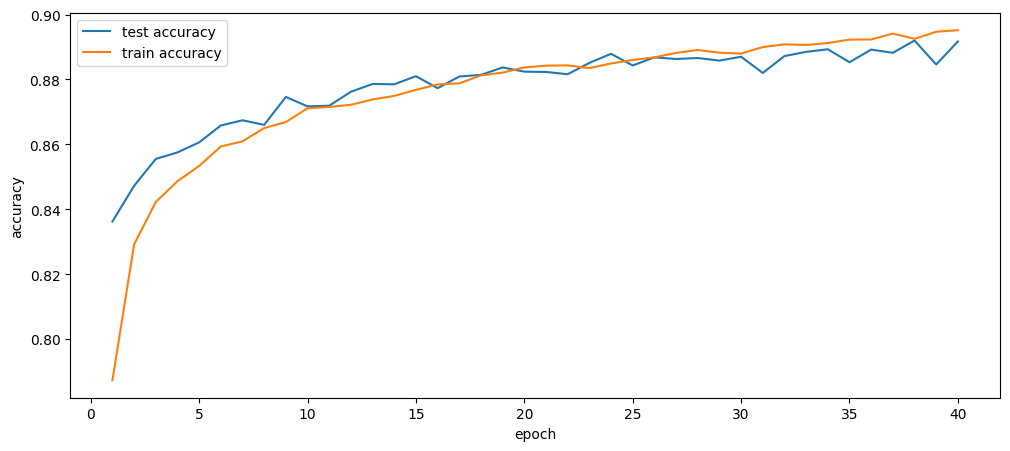

In [180]:
plt.figure(figsize = (12,5))
plt.plot(np.arange(1, num_epochs + 1), history_test_acc, label = 'test accuracy')
plt.plot(np.arange(1, num_epochs + 1), history_train_acc, label = 'train accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

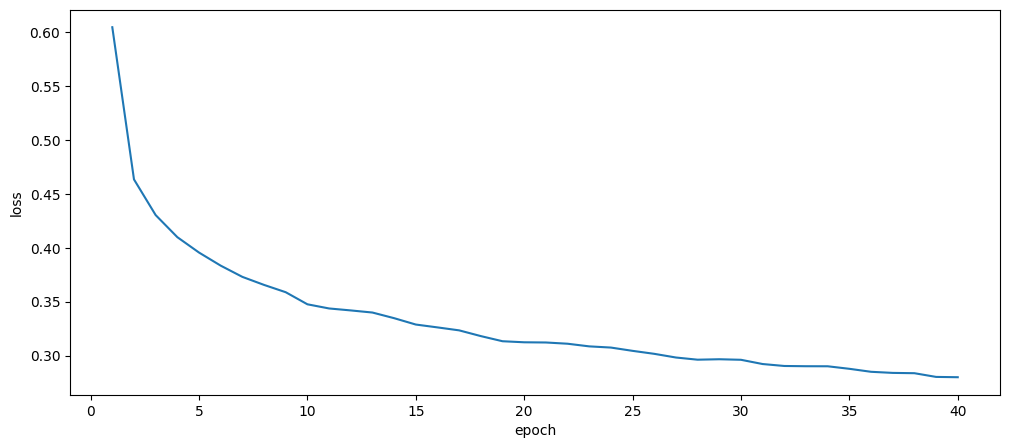

In [181]:
plt.figure(figsize = (12,5))
plt.plot(np.arange(1, num_epochs + 1), history_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [182]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28 * 28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 4000),
            nn.ReLU(),
            nn.Linear(4000, 512),
            nn.ReLU(),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [183]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 4000]       3,140,000
              ReLU-3                 [-1, 4000]               0
            Linear-4                  [-1, 512]       2,048,512
              ReLU-5                  [-1, 512]               0
            Linear-6                   [-1, 64]          32,832
              ReLU-7                   [-1, 64]               0
            Linear-8                   [-1, 10]             650
Total params: 5,221,994
Trainable params: 5,221,994
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 19.92
Estimated Total Size (MB): 20.00
----------------------------------------------------------------


Уменьшим размер train датасета до 30000.

In [184]:
from torch.utils.data import DataLoader, Subset
subset_indices = torch.randperm(len(fmnist_dataset_train))[:30000]
fmnist_dataset_train = Subset(fmnist_dataset_train, subset_indices)
train_loader = torch.utils.data.DataLoader(
    fmnist_dataset_train, batch_size=128, shuffle=True, num_workers=2
)

In [186]:
from sklearn.metrics import accuracy_score
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

num_epochs = 40
history_train_loss = []
history_test_loss = []
history_test_acc = []
history_train_acc = []
for epoch in range(num_epochs):
    model.train()
    ep_train_loss = []
    ep_test_loss = []
    train_pred, train_true = [], []
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        opt.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        opt.step()
        ep_train_loss.append(loss.item())
        pred_train = outputs.argmax(dim=1, keepdim=True)
        train_pred.extend(pred_train.tolist())
        train_true.extend(labels.tolist())
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            ep_test_loss.append(loss_func(outputs, labels).item())
            predictions = torch.argmax(outputs, dim=1)
            y_true.extend(labels.tolist())
            y_pred.extend(predictions.tolist())
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {np.mean(ep_train_loss):.4f}, Train acc: {accuracy_score(train_pred, train_true):.4f}, test acc: {accuracy_score(y_pred, y_true):.4f}')
    history_train_loss.append(np.mean(ep_train_loss))
    history_test_loss.append(np.mean(ep_test_loss))
    history_test_acc.append(accuracy_score(y_pred, y_true))
    history_train_acc.append(accuracy_score(train_pred, train_true))

Epoch 1/40, Loss: 0.6544, Train acc: 0.7595, test acc: 0.8143
Epoch 2/40, Loss: 0.4201, Train acc: 0.8475, test acc: 0.8378
Epoch 3/40, Loss: 0.3701, Train acc: 0.8630, test acc: 0.8478
Epoch 4/40, Loss: 0.3561, Train acc: 0.8678, test acc: 0.8301
Epoch 5/40, Loss: 0.3270, Train acc: 0.8805, test acc: 0.8516
Epoch 6/40, Loss: 0.3187, Train acc: 0.8845, test acc: 0.8660
Epoch 7/40, Loss: 0.3009, Train acc: 0.8882, test acc: 0.8634
Epoch 8/40, Loss: 0.2964, Train acc: 0.8895, test acc: 0.8689
Epoch 9/40, Loss: 0.2739, Train acc: 0.8979, test acc: 0.8643
Epoch 10/40, Loss: 0.2690, Train acc: 0.9012, test acc: 0.8689
Epoch 11/40, Loss: 0.2663, Train acc: 0.8993, test acc: 0.8579
Epoch 12/40, Loss: 0.2517, Train acc: 0.9064, test acc: 0.8715
Epoch 13/40, Loss: 0.2504, Train acc: 0.9080, test acc: 0.8738
Epoch 14/40, Loss: 0.2486, Train acc: 0.9076, test acc: 0.8736
Epoch 15/40, Loss: 0.2368, Train acc: 0.9103, test acc: 0.8660
Epoch 16/40, Loss: 0.2304, Train acc: 0.9128, test acc: 0.8743
E

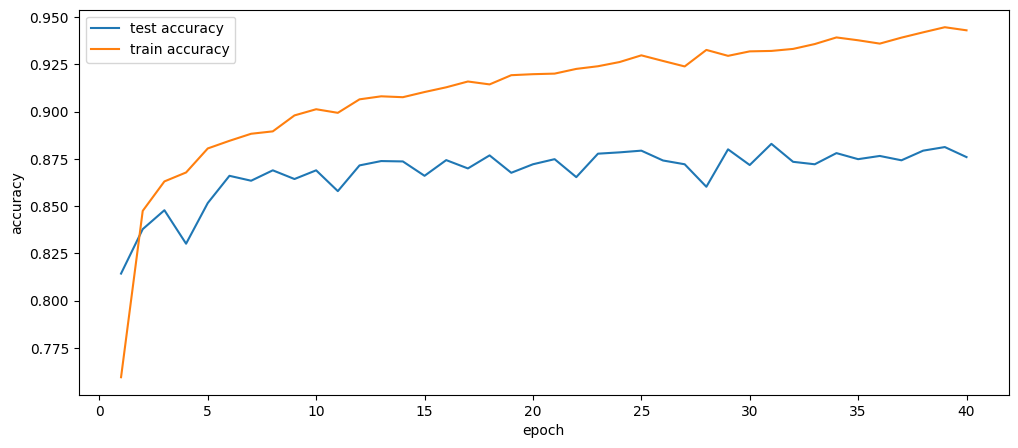

In [187]:
plt.figure(figsize = (12,5))
plt.plot(np.arange(1, num_epochs + 1), history_test_acc, label = 'test accuracy')
plt.plot(np.arange(1, num_epochs + 1), history_train_acc, label = 'train accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

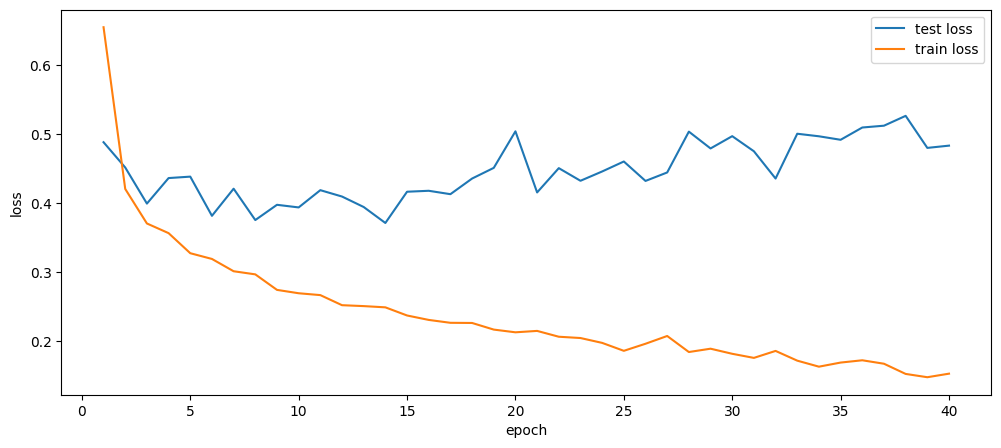

In [188]:
plt.figure(figsize = (12,5))
plt.plot(np.arange(1, num_epochs + 1), history_test_loss, label = 'test loss')
plt.plot(np.arange(1, num_epochs + 1), history_train_loss, label = 'train loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [200]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28 * 28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 4000),
            nn.BatchNorm1d(4000),
            nn.ReLU(),
            nn.Dropout(0.8),
            nn.Linear(4000, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(64, num_classes)
        )

    def forward(self, inp):
        out = self.model(inp)

In [201]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 4000]       3,140,000
       BatchNorm1d-3                 [-1, 4000]           8,000
              ReLU-4                 [-1, 4000]               0
           Dropout-5                 [-1, 4000]               0
            Linear-6                  [-1, 512]       2,048,512
       BatchNorm1d-7                  [-1, 512]           1,024
              ReLU-8                  [-1, 512]               0
           Dropout-9                  [-1, 512]               0
           Linear-10                   [-1, 64]          32,832
      BatchNorm1d-11                   [-1, 64]             128
             ReLU-12                   [-1, 64]               0
          Dropout-13                   [-1, 64]               0
           Linear-14                   

In [202]:
from sklearn.metrics import accuracy_score
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=10e-6)
loss_func = nn.CrossEntropyLoss()

num_epochs = 40
history_train_loss = []
history_test_loss = []
history_test_acc = []
history_train_acc = []
for epoch in range(num_epochs):
    model.train()
    ep_train_loss = []
    ep_test_loss = []
    train_pred, train_true = [], []
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        opt.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        opt.step()
        ep_train_loss.append(loss.item())
        pred_train = outputs.argmax(dim=1, keepdim=True)
        train_pred.extend(pred_train.tolist())
        train_true.extend(labels.tolist())
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            ep_test_loss.append(loss_func(outputs, labels).item())
            predictions = torch.argmax(outputs, dim=1)
            y_true.extend(labels.tolist())
            y_pred.extend(predictions.tolist())
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {np.mean(ep_train_loss):.4f}, Train acc: {accuracy_score(train_pred, train_true):.4f}, test acc: {accuracy_score(y_pred, y_true):.4f}')
    history_train_loss.append(np.mean(ep_train_loss))
    history_test_loss.append(np.mean(ep_test_loss))
    history_test_acc.append(accuracy_score(y_pred, y_true))
    history_train_acc.append(accuracy_score(train_pred, train_true))

Epoch 1/40, Loss: 0.6547, Train acc: 0.7540, test acc: 0.8193
Epoch 2/40, Loss: 0.4363, Train acc: 0.8420, test acc: 0.8446
Epoch 3/40, Loss: 0.3961, Train acc: 0.8552, test acc: 0.8383
Epoch 4/40, Loss: 0.3699, Train acc: 0.8652, test acc: 0.8416
Epoch 5/40, Loss: 0.3566, Train acc: 0.8683, test acc: 0.8511
Epoch 6/40, Loss: 0.3413, Train acc: 0.8745, test acc: 0.8605
Epoch 7/40, Loss: 0.3225, Train acc: 0.8808, test acc: 0.8409
Epoch 8/40, Loss: 0.3172, Train acc: 0.8833, test acc: 0.8491
Epoch 9/40, Loss: 0.3180, Train acc: 0.8829, test acc: 0.8556
Epoch 10/40, Loss: 0.3084, Train acc: 0.8852, test acc: 0.8493
Epoch 11/40, Loss: 0.2990, Train acc: 0.8897, test acc: 0.8567
Epoch 12/40, Loss: 0.2937, Train acc: 0.8923, test acc: 0.8663
Epoch 13/40, Loss: 0.2928, Train acc: 0.8904, test acc: 0.8635
Epoch 14/40, Loss: 0.2819, Train acc: 0.8950, test acc: 0.8601
Epoch 15/40, Loss: 0.2861, Train acc: 0.8947, test acc: 0.8547
Epoch 16/40, Loss: 0.2787, Train acc: 0.8958, test acc: 0.8687
E

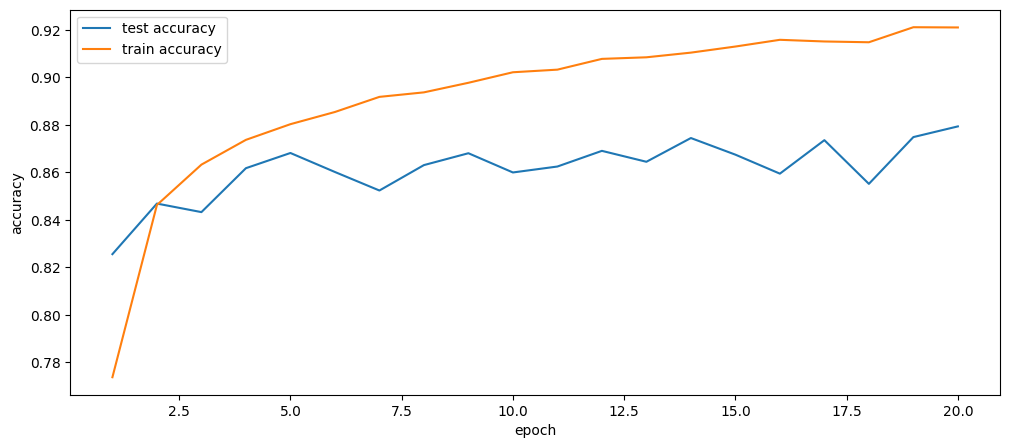

In [140]:
plt.figure(figsize = (12,5))
plt.plot(np.arange(1, num_epochs + 1), history_test_acc, label = 'test accuracy')
plt.plot(np.arange(1, num_epochs + 1), history_train_acc, label = 'train accuracy')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

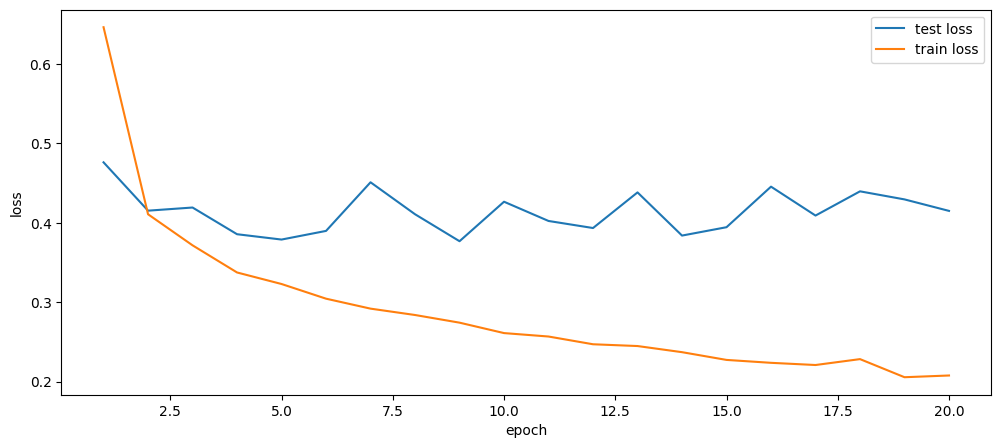

In [142]:
plt.figure(figsize = (12,5))
plt.plot(np.arange(1, num_epochs + 1), history_test_loss, label = 'test loss')
plt.plot(np.arange(1, num_epochs + 1), history_train_loss, label = 'train loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### Conclusions:
_Write down small report with your conclusions and your ideas._

С помощью регуляризации и dropout получилось немного уменьшить переобучение модели, однако test accuracy почти не изменилась. Также по экспрементировав с weight decay я понял, что этот параметр больше всего влияет на переобучаемость в данном случае.